In [1]:
import import_ipynb
import numpy as np
import pandas as pd
import pickle
import copy
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.optimize import fsolve
from scipy.special import rel_entr, kl_div
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from ipynb.fs.full.DFA_func import (plot_density_forecast, aggregating_algorithm,
                                    get_optim_m, get_optim_alpha, plot_optim_m_alpha, get_opt_arima, plot_AA_losses,
                                    get_auto_base_alg_list, adaptive_selection, adaptive_combination,
                                    get_all_predictions, get_all_predictions_AS, get_all_predictions_AC,
                                    plot_total_losses, plot_total_losses_all, plot_AS_losses, plot_AC_losses)

In [3]:
sunspot_ts = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
sunspot_ts.index = sunspot_ts['time'].values
sunspot_ts.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)
sunspot_ts.rename({'value': 'sunspot.year'}, axis=1, inplace=True)

**Пример использования**

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

m=3.5 - 0.6574654285871606, n_bins=12


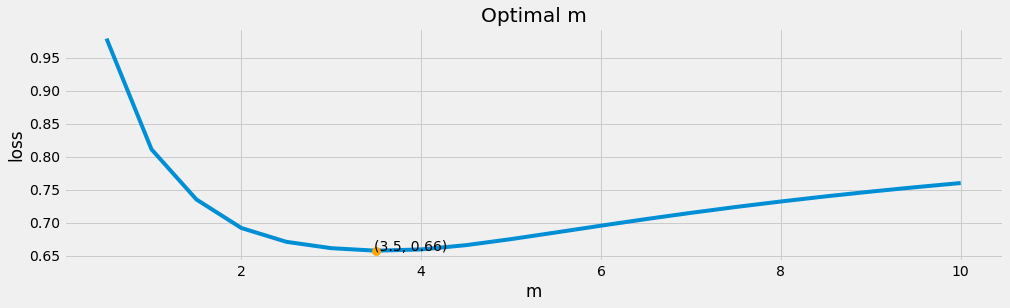

In [4]:
base_alg_list = [(Holt, {}, {}),
                 (SimpleExpSmoothing, {}, {}),
                 (ExponentialSmoothing, {}, {}),
                 (ExponentialSmoothing, {"trend": "additive"}, {}),
                 (ARIMA, {'order': (1, 2, 0)}, {})]
best_m, best_loss, n_bins, all_losses_dict = get_optim_m(sunspot_ts, base_alg_list,
                                                         bins=10, omega_mode="mean")

print(f"m={best_m} - {best_loss}, n_bins={n_bins}")

plt.figure(figsize=(15, 4))
plot_optim_m_alpha(all_losses_dict, best_m)
plt.title("Optimal m")
plt.xlabel("m")
plt.ylabel("loss");

  0%|          | 0/299 [00:00<?, ?it/s]

Theoretical bound met
ARIMA mean loss: 0.6181088282332917
Holt mean loss: 0.6234162076046837
ES_trend mean loss: 0.6234162076046837
AA mean loss: 0.6109168262429002


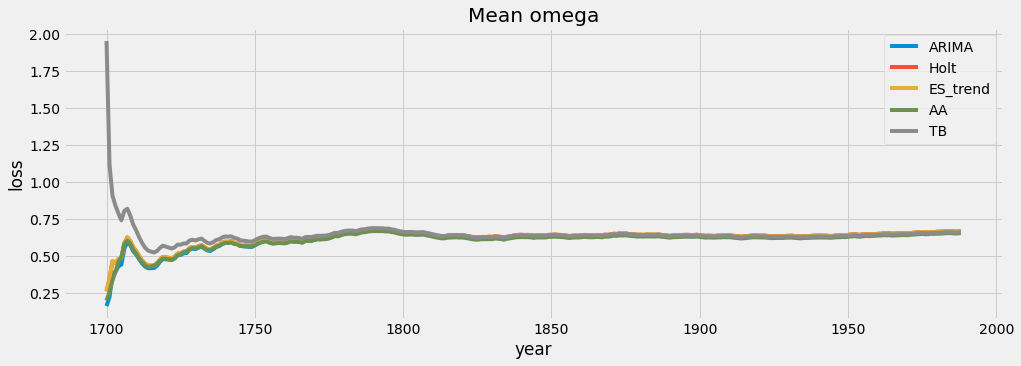

In [5]:
fig, ax = plt.subplots(1, figsize=(15,5))

plot_AA_losses(sunspot_ts, 10, base_alg_list,
               omega_mode="mean", bins=10, best_m=best_m, ax=ax,
               title="Mean omega", legend=['Holt', 'SES', 'ES', 'ES_trend', 'ARIMA', 'AA', 'Tb'], number_to_plot=3)
ax.set_xlabel('year')
ax.set_ylabel('loss');

## Предобработка данных

In [6]:
df = pd.read_csv('data/retail_dataset.csv')

df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index(['Date'], inplace=True)

df.head(3)

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22,163.78,NaN
2015-01-02,1,1,NaN,41,163.78,NaN
2015-01-03,1,1,NaN,35,163.78,NaN


In [7]:
df.Demand.isna().sum()

0

Определим актуальную цену с учётом промо

In [8]:
def get_actual_price(x):
    promo = x[0]
    regular_price = x[1]
    promo_price = x[2]
    
    if promo == 1:
        return promo_price
    else:
        return regular_price

In [9]:
df['Actual_Price'] = df[['Promo', 'Regular_Price', 'Promo_Price']].apply(
    get_actual_price, axis=1, result_type='reduce'
)

При этом можно предположить, что, к примеру, регулярная цена, равная 100, и промо цена 100 при регулярной цене 120 (скидка 20), могут по-разному влиять на спрос. Поэтому заполним пропущенные значения в Promo нулями, чтобы в дальнейшем данный бинарный признак можно было использовать.

In [10]:
df.Promo.fillna(0, inplace=True)
df.Promo = df.Promo.astype(int)

Визуализируем наши признаки для того, чтобы понять, как они связаны с целевой переменной. Для примера возьмём продажи обоих товаров в магазине со store_id = 1

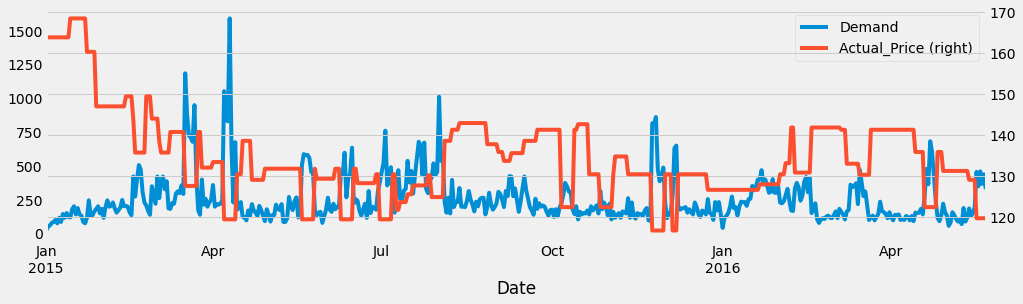

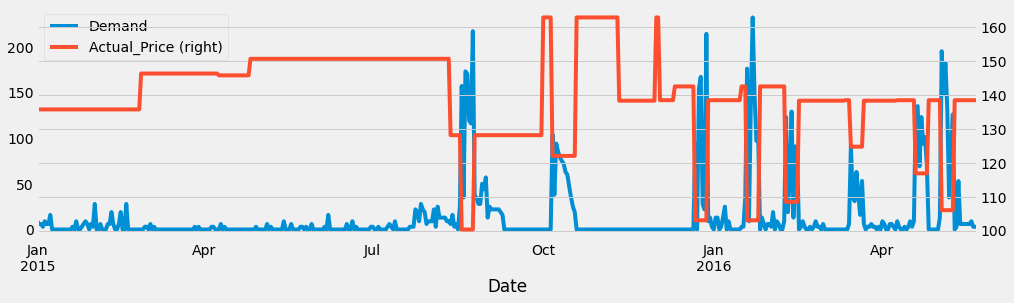

In [11]:
df[(df.Store_id == 10) & (df.SKU_id == 1)][['Demand', 'Actual_Price']].plot(
    secondary_y = ['Actual_Price'], figsize=(15,4));

for_plot = df[(df.Store_id == 1) & (df.SKU_id == 2)][['Demand','Actual_Price']]
for_plot.plot(secondary_y = ['Actual_Price'], figsize=(15,4));

## Разбиение на train и test

In [12]:
train_dict = {}
test_dict = {}

for store_id in df.Store_id.unique():
    for sku_id in df.SKU_id.unique():
        ts = df[(df.Store_id == store_id) & (df.SKU_id == sku_id)]["Demand"]
        actual_price = df[(df.Store_id == store_id) & (df.SKU_id == sku_id)]["Actual_Price"]
        promo = df[(df.Store_id == store_id) & (df.SKU_id == sku_id)]["Promo"]
        if not ts.empty and ts.size == 508:
            train_dict[f"sku{sku_id}_store{store_id}"] = {}
            train_dict[f"sku{sku_id}_store{store_id}"]["ts"] = ts.loc[:"2015-12-31"]
            train_dict[f"sku{sku_id}_store{store_id}"]["actual_price"] = actual_price.loc[:"2015-12-31"]
            train_dict[f"sku{sku_id}_store{store_id}"]["promo"] = promo.loc[:"2015-12-31"]
            
            test_dict[f"sku{sku_id}_store{store_id}"] = {}
            test_dict[f"sku{sku_id}_store{store_id}"]["ts"] = ts.loc["2016-01-01":]
            test_dict[f"sku{sku_id}_store{store_id}"]["actual_price"] = actual_price.loc["2016-01-01":]
            test_dict[f"sku{sku_id}_store{store_id}"]["promo"] = promo.loc["2016-01-01":]

Каждый элемент словаря содержит ещё один словарь, состоязий из трёх pandas.Series

Всего 145 уникальных временных рядов длиной 508 тайм стемпов.

In [13]:
len(train_dict), len(test_dict)

(145, 145)

train состоит из 365 тайм стемпов, а test из 143

In [14]:
train_dict['sku1_store1']['ts'].size, test_dict['sku1_store1']['ts'].size

(365, 143)

## Подбор базовых алгоритмов

### ARIMA

In [15]:
arima_000_000_0 = ARIMA(endog=train_dict["sku1_store1"]["ts"],
                        exog=(pd.DataFrame(data=[train_dict["sku1_store1"]["actual_price"],
                                                 train_dict["sku1_store1"]["promo"]])
                              .transpose().astype({"Actual_Price": float, "Promo": int})),
                        order=(0, 0, 0)).fit()

print(arima_000_000_0.summary())

                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                  365
Model:                          ARIMA   Log Likelihood               -2563.144
Date:                Tue, 25 Jan 2022   AIC                           5134.287
Time:                        00:24:49   BIC                           5149.887
Sample:                    01-01-2015   HQIC                          5140.487
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          750.5173    508.034      1.477      0.140    -245.212    1746.247
Actual_Price    -4.3362      3.729     -1.163      0.245     -11.644       2.972
Promo          455.0629     73.164      6.22

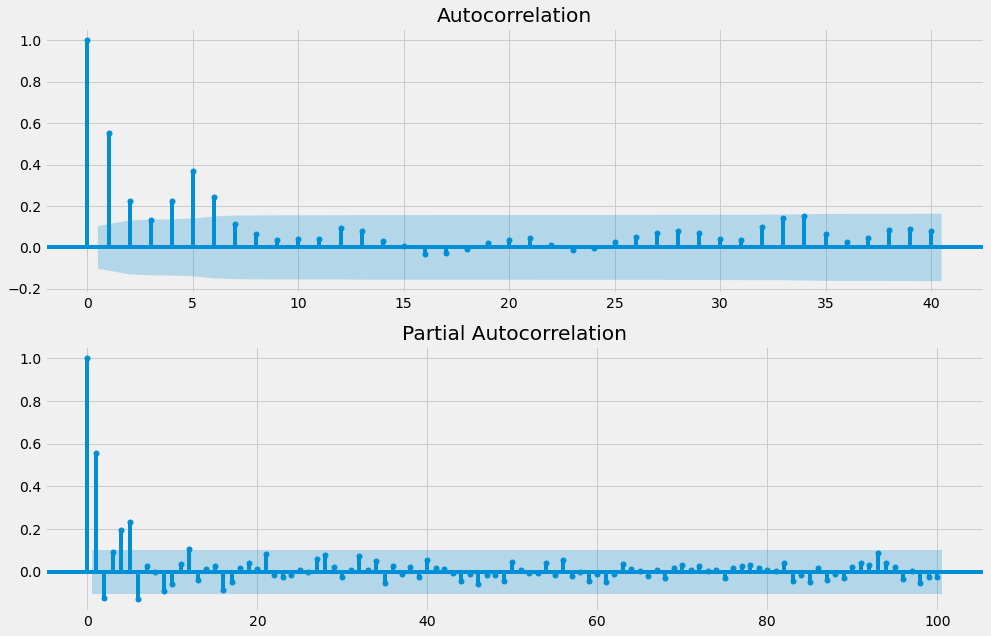

In [16]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_000_000_0.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_000_000_0.resid.values.squeeze(), lags=100, ax=ax2)

Возможные варианты параметров:

p = {0, 1, 2, 3, 4, 5, 6}

q = {0, 1, 2, 3, 4, 5, 6}

In [17]:
endog = train_dict["sku1_store1"]["ts"]
exog = (pd.DataFrame(data=[train_dict["sku1_store1"]["actual_price"],
                         train_dict["sku1_store1"]["promo"]])
      .transpose().astype({"Actual_Price": float, "Promo": int}))

grid_params = {'p': [0, 1, 2, 3, 4, 5, 6], 'd': [0], 'q': [0, 1, 2, 3, 4, 5, 6],
               'P': [0], 'D': [0], 'Q': [0], 's': [0]}

opt_model = get_opt_arima(endog, exog, grid_params)
print(opt_model)

  0%|          | 0/49 [00:00<?, ?it/s]

{'opt_params': {'order': (0, 0, 6), 'seasonal_order': (0, 0, 0, 0)}, 'opt_bic': 4998.701876416547, 'opt_model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x7ffdb85a9130>}


In [18]:
print(opt_model['opt_model'].summary())

                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                  365
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -2469.851
Date:                Tue, 25 Jan 2022   AIC                           4959.703
Time:                        00:25:09   BIC                           4998.702
Sample:                    01-01-2015   HQIC                          4975.202
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          750.8097    643.434      1.167      0.243    -510.297    2011.916
Actual_Price    -4.3700      4.862     -0.899      0.369     -13.899       5.159
Promo          455.7698     58.366      7.80

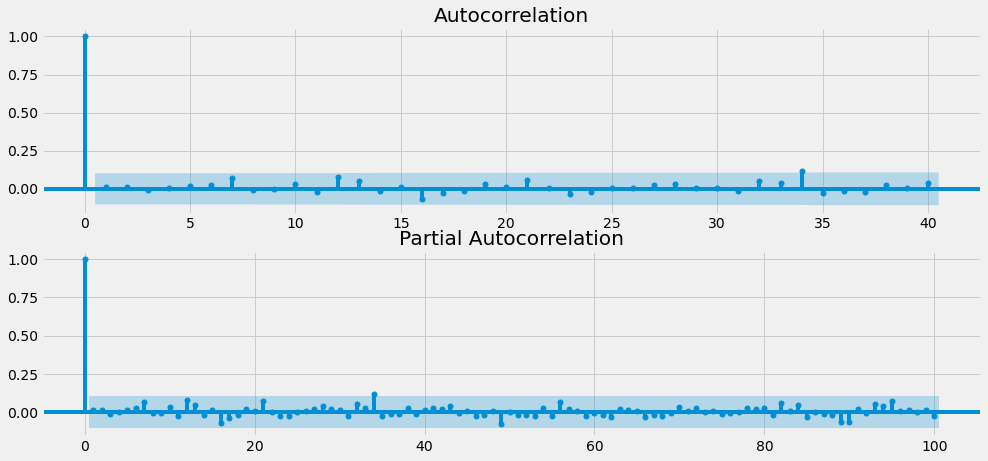

In [19]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(opt_model['opt_model'].resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(opt_model['opt_model'].resid.values.squeeze(), lags=100, ax=ax2)

### ES

In [20]:
SES = ExponentialSmoothing(train_dict["sku1_store1"]["ts"]).fit(optimized=True)
ES_add7 = ExponentialSmoothing(train_dict["sku1_store1"]["ts"], seasonal="add",
                           seasonal_periods=7).fit(optimized=True)

In [21]:
SES.summary()

Dep. Variable:,Demand,No. Observations:,365
Model:,ExponentialSmoothing,SSE,31641209.460
Optimized:,True,AIC,4154.077
Trend:,None,BIC,4161.877
Seasonal:,None,AICC,4154.188
Seasonal Periods:,None,Date:,"Tue, 25 Jan 2022"
Box-Cox:,False,Time:,00:25:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6194948,alpha,True
initial_level,29.451987,l.0,True


In [22]:
ES_add7.summary()

Dep. Variable:,Demand,No. Observations:,365
Model:,ExponentialSmoothing,SSE,31490579.121
Optimized:,True,AIC,4166.335
Trend:,None,BIC,4201.434
Seasonal:,Additive,AICC,4167.083
Seasonal Periods:,7,Date:,"Tue, 25 Jan 2022"
Box-Cox:,False,Time:,00:25:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6223781,alpha,True
smoothing_seasonal,0.0143521,gamma,True


### Итоговый набор базовых алгоритмов

По итогу, для данной задачи всего будет 8 базовых алгоритмов:

1. **Auto SARIMAX**. Экзогенные переменные: Actual Price and Promo. Подбор p и q в диапазоне [0, 6].
2. **Auto SES**. Автоматический подбор $\alpha$ (smoothing of level).
3. **Auto ES with additive seasonality (s=7)**. Автоматический подбор $\alpha$ (smoothing of level) and $\gamma$ (smoothing of seasonality).

Эти три модели будут автоматически настривается на основе обучающих данных для каждого временного ряда в отдельности. 

Помимо автоматических моделей будет ещё 5 базовых алгоритмов:

4. **SES with $\alpha=0.9$**
5. **SES with $\alpha=0.4$**
6. **ES with additive seasonality (s=7) and $\alpha=0.8$, $\gamma=0.6$**
7. **ES with additive seasonality (s=7) and $\alpha=0.4$, $\gamma=0.9$**
8. **ES with additive seasonality (s=7) and $\alpha=0.4$, $\gamma=0.1$**


### Построение агрегирующего алгоритма

Алгоритм построения агрегирующего алгоритма выглядит следующим образом:
1. На вход поступает временной ряд. 
2. На основе обучающей выборки рассчитываются базовые алгоритмы.
3. На обучающей выборке подбирается оптимальное значение m.
4. Далее строится агрегирующий алгоритм на тестовых данных. 

Ниже представлен пример данного алгоритма для одного временного ряда.

In [23]:
endog_train = train_dict["sku1_store66"]["ts"]
exog_train = (pd.DataFrame(data=[train_dict["sku1_store66"]["actual_price"],
                         train_dict["sku1_store66"]["promo"]])
      .transpose().astype({"Actual_Price": float, "Promo": int}))
grid_params = {'p': [0, 1, 2, 3, 4, 5, 6], 'd': [0], 'q': [0, 1, 2, 3, 4, 5, 6],
               'P': [0], 'D': [0], 'Q': [0], 's': [0]}

base_alg_list = [
    (ExponentialSmoothing, {}, {"smoothing_level": 0.9}),
    (ExponentialSmoothing, {}, {"smoothing_level": 0.4}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.8, "smoothing_seasonal": 0.6}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.9}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.1})
                 ]

auto_base_alg_list = get_auto_base_alg_list(endog_train, exog_train, grid_params)

base_alg_list.extend(auto_base_alg_list)
len(base_alg_list)


  0%|          | 0/49 [00:00<?, ?it/s]

8

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

m=3.0 - 0.3310575133692494, n_bins=10


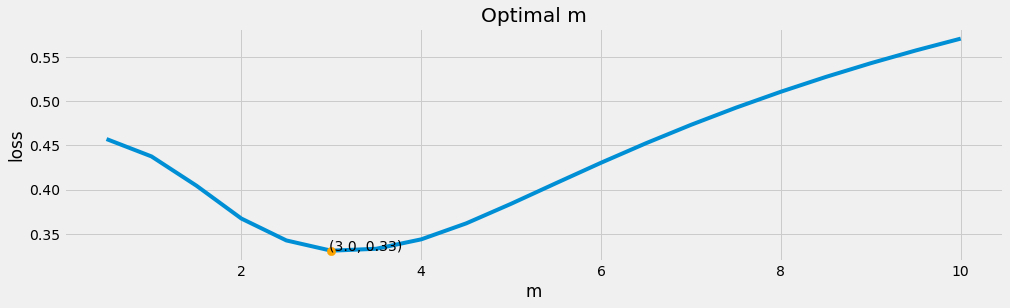

In [24]:
best_m, best_loss, n_bins, all_losses_dict = get_optim_m(endog_train, base_alg_list, exog=exog_train,
                                                         bins=10, omega_mode="basic")

print(f"m={best_m} - {best_loss}, n_bins={n_bins}")

plt.figure(figsize=(15, 4))
plot_optim_m_alpha(all_losses_dict, best_m)
plt.title("Optimal m")
plt.xlabel("m")
plt.ylabel("loss");

  0%|          | 0/143 [00:00<?, ?it/s]

Theoretical bound met
Auto_ARIMA mean loss: 0.5416602480659144
Auto_SES mean loss: 0.5613258162037276
SES2 mean loss: 0.5651979601528188
AA mean loss: 0.5242601777866945


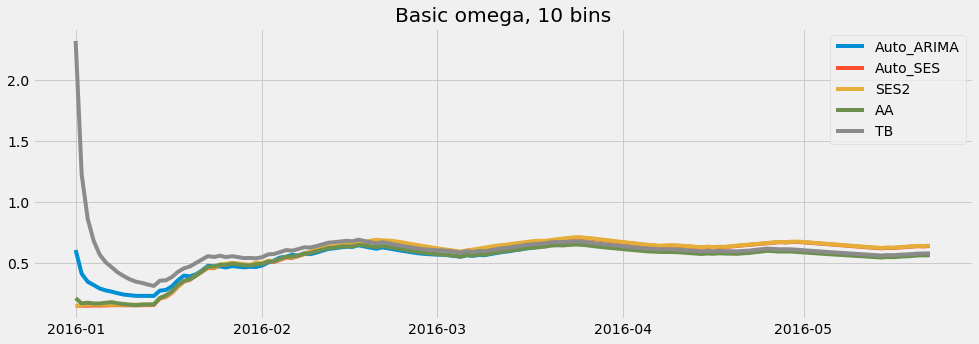

In [25]:
endog_test = test_dict["sku1_store66"]["ts"]
exog_test = (pd.DataFrame(data=[test_dict["sku1_store66"]["actual_price"],
                                test_dict["sku1_store66"]["promo"]])
      .transpose().astype({"Actual_Price": float, "Promo": int}))


fig, ax = plt.subplots(1, figsize=(15,5))

sku1_66_losses = plot_AA_losses(endog_test, 0, base_alg_list, exog=exog_test,
                                omega_mode="basic", bins=10, best_m=best_m, ax=ax,
                                title="Basic omega, 10 bins", legend=['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                                                                      'Auto_ARIMA', 'Auto_SES', 'Auto_ES',
                                                                      'AA', 'TB'], number_to_plot=3)

### Анализ результатов (AA vs Base Algorithms)

Построение агрегирующего алгоритма для всех временных рядов (всего их 145)

In [26]:
# grid_params = {'p': [0, 1, 2, 3, 4, 5, 6], 'd': [0], 'q': [0, 1, 2, 3, 4, 5, 6],
#                'P': [0], 'D': [0], 'Q': [0], 's': [0]}

# base_alg_list = [
#     (ExponentialSmoothing, {}, {"smoothing_level": 0.9}),
#     (ExponentialSmoothing, {}, {"smoothing_level": 0.4}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.8, "smoothing_seasonal": 0.6}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.9}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.1})
#                  ]

In [27]:
# pred_dict_AA, losses_dict_AA = get_all_predictions(train_dict, test_dict, 0, base_alg_list, grid_params,
#                                              omega_mode="basic", best_m="optim", is_exog=True, bins=10)

In [28]:
# with open('data/losses_dict_AA.pickle', 'wb') as file:
#     pickle.dump(losses_dict_AA, file, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/pred_dict_AA.pickle', 'wb') as file:
#     pickle.dump(pred_dict_AA, file, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('data/losses_dict_AA.pickle', 'rb') as file:
    losses_dict_AA = pickle.load(file)

with open('data/pred_dict_AA.pickle', 'rb') as file:
    pred_dict_AA = pickle.load(file)

Auto_ARIMA mean loss: 0.41903868750741324
SES1 mean loss: 0.44970145572119175
Auto_SES mean loss: 0.45454353375828305
Auto_ES mean loss: 0.47144181569830346
SES2 mean loss: 0.4821647026031299
AA mean loss: 0.4059580283938564


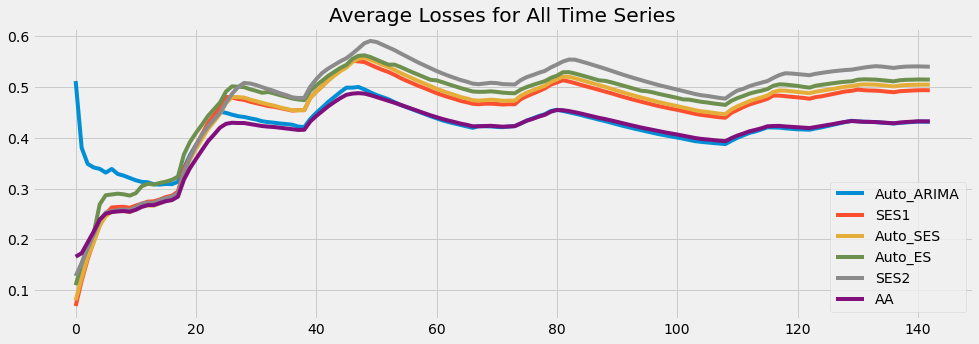

In [30]:
fig, ax = plt.subplots(1, figsize=(15,5))

plot_total_losses(losses_dict_AA, ax, "Average Losses for All Time Series",
                  ['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                   'Auto_ARIMA', 'Auto_SES', 'Auto_ES', 'AA'],
                  number_to_plot=5)

##  Сравнение с другими методами композиции алгоритмов (Adaptive Selection and Adaptive Combination)

In [31]:
endog_train = train_dict["sku1_store66"]["ts"]
exog_train = (pd.DataFrame(data=[train_dict["sku1_store66"]["actual_price"],
                         train_dict["sku1_store66"]["promo"]])
      .transpose().astype({"Actual_Price": float, "Promo": int}))
grid_params = {'p': [0, 1, 2, 3, 4, 5, 6], 'd': [0], 'q': [0, 1, 2, 3, 4, 5, 6],
               'P': [0], 'D': [0], 'Q': [0], 's': [0]}

base_alg_list = [
    (ExponentialSmoothing, {}, {"smoothing_level": 0.9}),
    (ExponentialSmoothing, {}, {"smoothing_level": 0.4}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.8, "smoothing_seasonal": 0.6}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.9}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.1})
                 ]

auto_base_alg_list = get_auto_base_alg_list(endog_train, exog_train, grid_params)

base_alg_list.extend(auto_base_alg_list)
len(base_alg_list)

  0%|          | 0/49 [00:00<?, ?it/s]

8

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

m=3.0 - 0.3310575133692494, n_bins=10


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

alpha_AS=0.1 - 0.3649167078114972, n_bins=10


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

alpha_AC=0.8 - 0.34345256163748183, n_bins=10


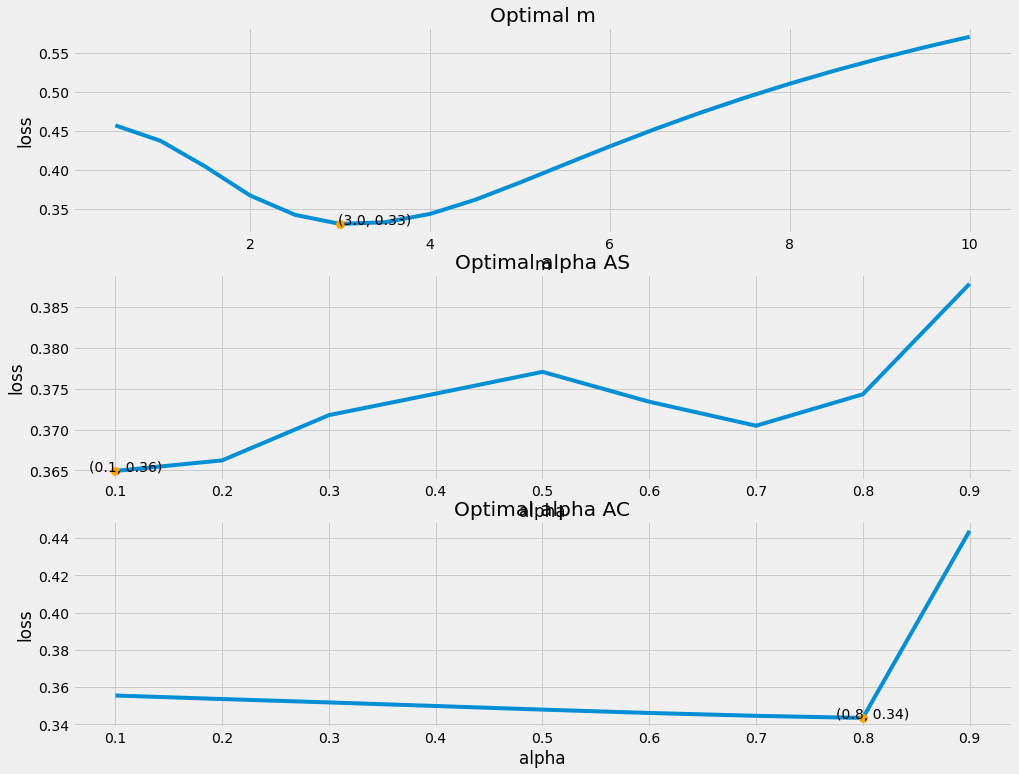

In [32]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 12))

best_m, best_loss, n_bins, AA_losses_dict = get_optim_m(endog_train, base_alg_list, exog=exog_train,
                                                         bins=10, omega_mode="basic")

print(f"m={best_m} - {best_loss}, n_bins={n_bins}")

best_alpha_AS, best_loss, n_bins, AS_losses_dict = get_optim_alpha(endog_train, adaptive_selection, base_alg_list,
                                                                    exog=exog_train, bins=10, omega_mode="basic")

print(f"alpha_AS={best_alpha_AS} - {best_loss}, n_bins={n_bins}")

best_alpha_AC, best_loss, n_bins, AC_losses_dict = get_optim_alpha(endog_train, adaptive_combination, base_alg_list,
                                                                    exog=exog_train, bins=10, omega_mode="basic")

print(f"alpha_AC={best_alpha_AC} - {best_loss}, n_bins={n_bins}")

plot_optim_m_alpha(AA_losses_dict, best_m, ax=ax[0])
ax[0].set_title("Optimal m")
ax[0].set_xlabel("m")
ax[0].set_ylabel("loss");

plot_optim_m_alpha(AS_losses_dict, best_alpha_AS, ax=ax[1])
ax[1].set_title("Optimal alpha AS")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("loss");

plot_optim_m_alpha(AC_losses_dict, best_alpha_AC, ax=ax[2])
ax[2].set_title("Optimal alpha AC")
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("loss");

  0%|          | 0/143 [00:00<?, ?it/s]

Theoretical bound met
Auto_ARIMA mean loss: 0.5416602480659144
Auto_SES mean loss: 0.5613258162037276
SES2 mean loss: 0.5651979601528188
AA mean loss: 0.5242601777866945


  0%|          | 0/142 [00:00<?, ?it/s]

Auto_ARIMA mean loss: 0.5416602480659144
Auto_SES mean loss: 0.5613258162037276
SES2 mean loss: 0.5651979601528188
AS mean loss: 0.5478202813829202


  0%|          | 0/143 [00:00<?, ?it/s]

Auto_ARIMA mean loss: 0.5416602480659144
Auto_SES mean loss: 0.5613258162037276
SES2 mean loss: 0.5651979601528188
AC mean loss: 0.5416992249758631


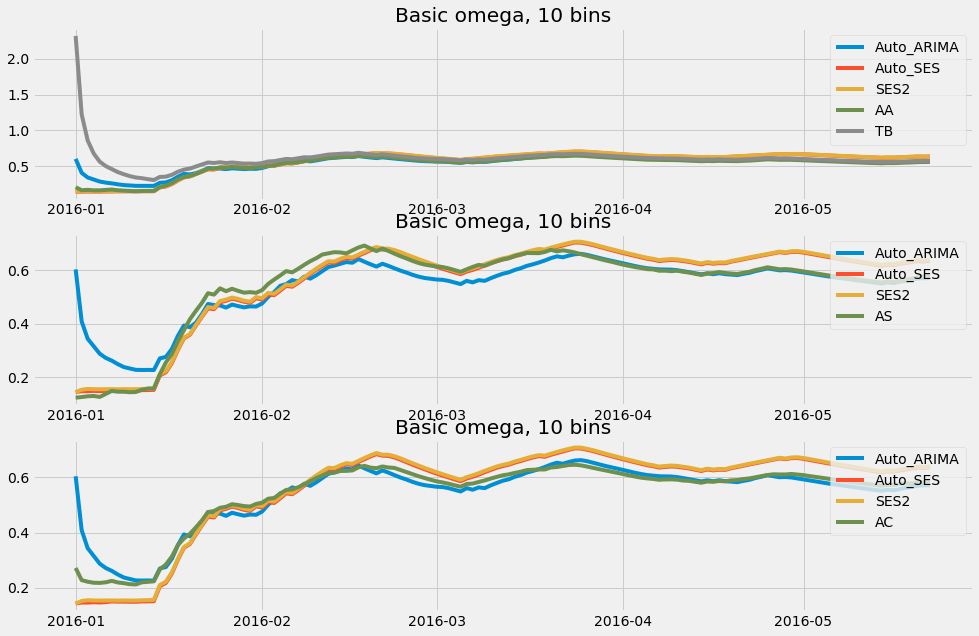

In [33]:
endog_test = test_dict["sku1_store66"]["ts"]
exog_test = (pd.DataFrame(data=[test_dict["sku1_store66"]["actual_price"],
                                test_dict["sku1_store66"]["promo"]])
      .transpose().astype({"Actual_Price": float, "Promo": int}))


fig, ax = plt.subplots(nrows=3, figsize=(15,10))

sku1_66_AA_losses = plot_AA_losses(endog_test, 0, base_alg_list, exog=exog_test,
                             omega_mode="basic", bins=10, best_m=best_m, ax=ax[0],
                             title="Basic omega, 10 bins", legend=['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                                                                      'Auto_ARIMA', 'Auto_SES', 'Auto_ES',
                                                                      'AA', 'TB'], number_to_plot=3)
sku1_66_AS_losses = plot_AS_losses(endog_test, 0, base_alg_list, exog=exog_test,
                             omega_mode="basic", bins=10, best_alpha=best_alpha_AS, ax=ax[1],
                             title="Basic omega, 10 bins", legend=['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                                                                      'Auto_ARIMA', 'Auto_SES', 'Auto_ES',
                                                                      'AA'], number_to_plot=3)

sku1_66_AC_losses = plot_AC_losses(endog_test, 0, base_alg_list, exog=exog_test,
                             omega_mode="basic", bins=10, best_alpha=best_alpha_AC, ax=ax[2],
                             title="Basic omega, 10 bins", legend=['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                                                                      'Auto_ARIMA', 'Auto_SES', 'Auto_ES',
                                                                      'AA'], number_to_plot=3)

**Построение адаптивной селекции и адаптивной комбинации для всех временных рядов**

In [34]:
# grid_params = {'p': [0, 1, 2, 3, 4, 5, 6], 'd': [0], 'q': [0, 1, 2, 3, 4, 5, 6],
#                'P': [0], 'D': [0], 'Q': [0], 's': [0]}

# base_alg_list = [
#     (ExponentialSmoothing, {}, {"smoothing_level": 0.9}),
#     (ExponentialSmoothing, {}, {"smoothing_level": 0.4}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.8, "smoothing_seasonal": 0.6}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.9}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.4, "smoothing_seasonal": 0.1})
#                  ]

In [35]:
# pred_dict_AS, losses_dict_AS = get_all_predictions_AS(train_dict, test_dict, 0, base_alg_list, grid_params,
#                                                       omega_mode="basic", best_alpha="optim", is_exog=True, bins=10)

# with open('data/losses_dict_AS.pickle', 'wb') as file:
#     pickle.dump(losses_dict_AS, file, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/pred_dict_AS.pickle', 'wb') as file:
#     pickle.dump(pred_dict_AS, file, protocol=pickle.HIGHEST_PROTOCOL)

Auto_ARIMA mean loss: 0.41903868750741324
SES1 mean loss: 0.44970145572119175
Auto_SES mean loss: 0.45454353375828305
Auto_ES mean loss: 0.47144181569830346
SES2 mean loss: 0.4821647026031299
AS mean loss: 0.4171845959491305


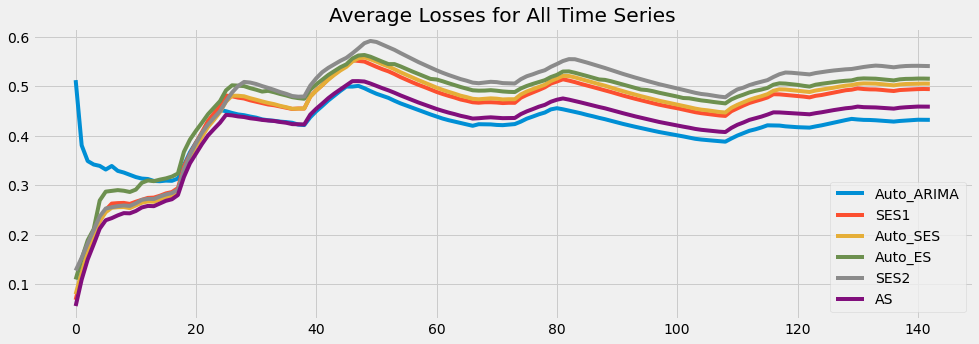

In [36]:
with open('data/losses_dict_AS.pickle', 'rb') as file:
    losses_dict_AS = pickle.load(file)

with open('data/pred_dict_AS.pickle', 'rb') as file:
    pred_dict_AS = pickle.load(file)

fig, ax = plt.subplots(1, figsize=(15,5))

plot_total_losses(losses_dict_AS, ax, "Average Losses for All Time Series",
                  ['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                   'Auto_ARIMA', 'Auto_SES', 'Auto_ES', 'AS'],
                  number_to_plot=5)

In [37]:
# pred_dict_AC, losses_dict_AC = get_all_predictions_AC(train_dict, test_dict, 0, base_alg_list, grid_params,
#                                                       omega_mode="basic", best_alpha="optim", is_exog=True, bins=10)

# with open('data/losses_dict_AC.pickle', 'wb') as file:
#     pickle.dump(losses_dict_AC, file, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/pred_dict_AC.pickle', 'wb') as file:
#     pickle.dump(pred_dict_AC, file, protocol=pickle.HIGHEST_PROTOCOL)

Auto_ARIMA mean loss: 0.41903868750741324
SES1 mean loss: 0.44970145572119175
Auto_SES mean loss: 0.45454353375828305
Auto_ES mean loss: 0.47144181569830346
SES2 mean loss: 0.4821647026031299
AC mean loss: 0.4087710841630158


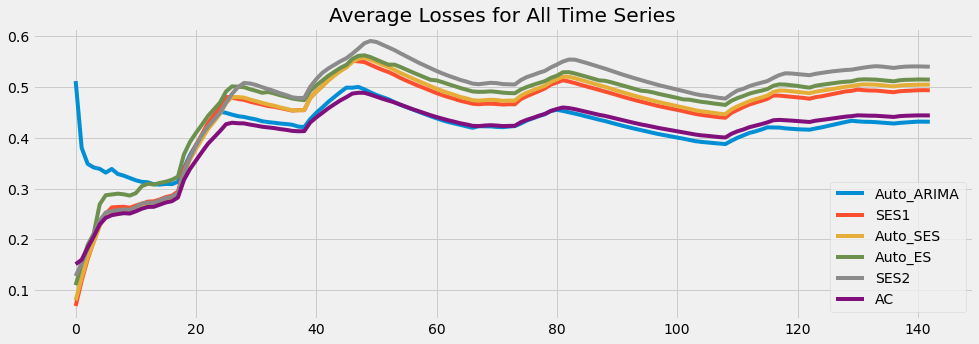

In [38]:
with open('data/losses_dict_AC.pickle', 'rb') as file:
    losses_dict_AC = pickle.load(file)

with open('data/pred_dict_AC.pickle', 'rb') as file:
    pred_dict_AC = pickle.load(file)

fig, ax = plt.subplots(1, figsize=(15,5))

plot_total_losses(losses_dict_AC, ax, "Average Losses for All Time Series",
                  ['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                   'Auto_ARIMA', 'Auto_SES', 'Auto_ES', 'AC'],
                  number_to_plot=5)

**Итоговое сравнение**

In [39]:
losses_dict_all = copy.deepcopy(losses_dict_AS)
for ts_name, losses in losses_dict_all.items():
    losses['AC'] = losses_dict_AC[ts_name]['AC']
    losses['AA'] = losses_dict_AA[ts_name]['AA']

Auto_ARIMA mean loss: 0.41903868750741324
AS mean loss: 0.4171845959491305
AC mean loss: 0.4087710841630158
AA mean loss: 0.4059580283938564


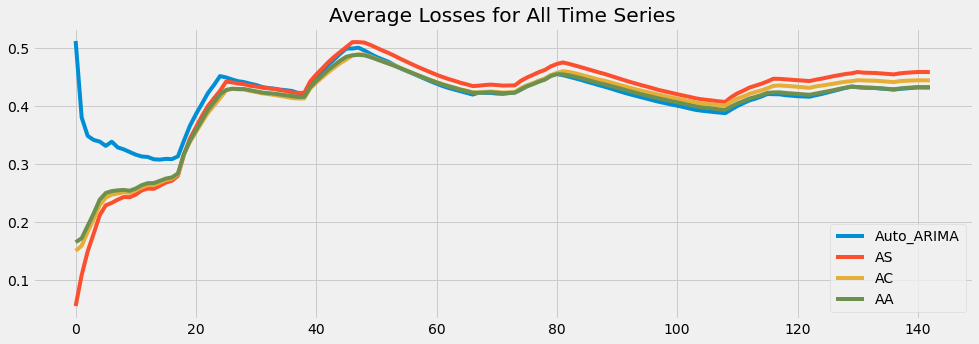

In [40]:
fig, ax = plt.subplots(1, figsize=(15,5))

plot_total_losses_all(losses_dict_all, ax, "Average Losses for All Time Series",
                  ['SES1', 'SES2', 'ES1', 'ES1', 'ES3',
                   'Auto_ARIMA', 'Auto_SES', 'Auto_ES', 'AS', 'AC', 'AA'],
                  number_to_plot=1)

| Model:       	| Best BA Auto ARIMAX 	| Adaptive Selection 	| Adaptive Combination 	| Aggregating Algorithm 	|
|--------------	|:-------------------:	|:------------------:	|:--------------------:	|:---------------------:	|
| Brier Loss   	|        0.419        	|        0.417       	|         0.409        	|         0.406         	|
| 100% Best BA 	|         100%        	|        99.5%       	|         97.6%        	|         96.9%         	|